In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

In [3]:
# Read Data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [4]:
spectra = spectrum_test.columns

In [5]:
def rename_columns(df):
    new_df = df
    for i in range(len(df.columns)):
        new_df.columns.values[i] = int(i)

    return new_df

In [6]:
spectrum_train_scaled = spectrum_train.multiply(10**12)
spectrum_test_scaled = spectrum_test.multiply(10**12)

In [7]:
# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 0

if direction:
    X_train = temp_train
    X_test = temp_test
    y_train = spectrum_train_scaled
    y_test = spectrum_test_scaled
else:
    X_train = spectrum_train_scaled
    X_test = spectrum_test_scaled
    y_train = temp_train
    y_test = temp_test

In [8]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [9]:
input_data = df_to_tensor(X_train)
output_data = df_to_tensor(y_train)

In [20]:
input_data.dtype

torch.float32

In [11]:
output_data

tensor([[350.6424, 357.4240, 338.0000,  ..., 267.9975, 252.9999, 238.0000],
        [352.1875, 360.3629, 342.0451,  ..., 269.5426, 252.9999, 236.4549],
        [350.6424, 357.4240, 338.0000,  ..., 267.9975, 252.9999, 238.0000],
        ...,
        [597.3622, 585.6775, 574.4026,  ..., 493.7609, 505.0429, 515.4084],
        [595.8171, 582.7385, 570.3576,  ..., 492.2158, 505.0429, 516.9536],
        [601.9975, 594.4943, 586.5379,  ..., 498.3961, 505.0429, 510.7732]])

In [12]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [13]:
input_size = len(X_train.columns)
output_size = len(y_train.columns)
model = Net(input_size=input_size, output_size=output_size)

In [14]:
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Rprop(model.parameters(), lr=0.001) 

In [15]:
num_epochs = 15
batch_size = 10
num_batches = len(input_data) // batch_size

for epoch in range(num_epochs):
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size

        inputs = input_data[start:end]
        targets = output_data[start:end]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

Epoch 1/15, Loss: 12163.505859
Epoch 2/15, Loss: 15033.250000
Epoch 3/15, Loss: 10657.819336
Epoch 4/15, Loss: 2072.461182
Epoch 5/15, Loss: 11086.554688
Epoch 6/15, Loss: 2650.423340
Epoch 7/15, Loss: 9103.344727
Epoch 8/15, Loss: 12659.381836
Epoch 9/15, Loss: 6636.558594
Epoch 10/15, Loss: 3642.833496
Epoch 11/15, Loss: 2126.919678
Epoch 12/15, Loss: 1758.910767
Epoch 13/15, Loss: 4187.854980
Epoch 14/15, Loss: 2780.589600
Epoch 15/15, Loss: 15146.896484


In [16]:
pred = model(df_to_tensor(X_test))
pred = pd.DataFrame(pred.detach().numpy())

actual = y_test

In [17]:
actual

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,layer 11
0,410.761201,412.678794,409.482872,401.948393,398.928932,397.948393,401.340736,408.678794,416.761201,421.621765,421.254224
1,408.690133,411.339048,412.411804,410.608647,411.000000,407.948393,403.411804,400.018540,399.690133,402.961511,409.183156
2,414.296735,417.678794,413.018406,401.948393,395.393398,392.948393,397.805202,408.678794,420.296735,426.621765,424.789758
3,411.190133,415.669175,417.411804,414.938774,413.500000,407.948393,400.911804,395.688413,394.690133,398.631384,406.683156
4,415.482872,416.788008,412.019461,402.726045,398.928932,398.726045,403.877325,412.788008,421.482872,425.993518,424.749862
...,...,...,...,...,...,...,...,...,...,...,...
187,436.774735,436.923029,434.535200,429.508573,422.117706,412.422590,400.500000,399.432209,399.617706,403.527811,412.035200
188,441.589259,440.490277,433.688774,422.682012,411.351522,403.589067,400.928932,413.589067,425.493658,432.682012,433.688774
189,439.518192,439.150531,436.617706,431.342266,423.422590,413.589067,403.000000,404.928813,408.422590,414.021758,421.617706
190,445.124793,445.490277,437.224308,422.682012,407.815988,398.589067,397.393398,413.589067,429.029191,437.682012,437.224308


In [18]:
pred

,0,1,2,3,4,5,6,7,8,9,10
0,113.161179,172.287643,196.526871,102.830627,56.380997,180.598282,245.068222,195.976440,286.898010,201.156723,208.852707
1,73.978607,144.130188,170.020264,66.539536,16.872253,149.540588,213.224533,167.629868,268.408386,170.394562,175.891510
2,124.829391,180.669647,204.418488,113.636246,68.144028,189.844833,254.552002,204.417465,292.398438,210.318542,218.668152
3,65.849075,138.285172,164.518967,59.008667,8.673431,143.097031,206.617493,161.746597,264.566895,164.013687,169.054962
4,125.200150,180.943710,204.673996,113.981476,68.520737,190.134628,254.854980,204.692642,292.584839,210.605042,218.971039
...,...,...,...,...,...,...,...,...,...,...,...
187,80.960526,149.147583,174.744446,73.003418,23.910782,155.075119,218.898544,172.679764,271.695740,175.877075,181.766495
188,152.970810,200.892349,223.457413,139.694473,96.513992,212.140686,277.426727,224.781586,305.665405,232.413025,242.331345
189,109.735458,169.818466,194.206894,99.649643,52.919968,177.884140,242.283630,193.491302,285.255249,198.472946,205.979309
190,165.813522,210.119537,232.144547,151.587784,109.460953,222.315018,287.866211,234.075348,311.723267,242.497040,253.128677


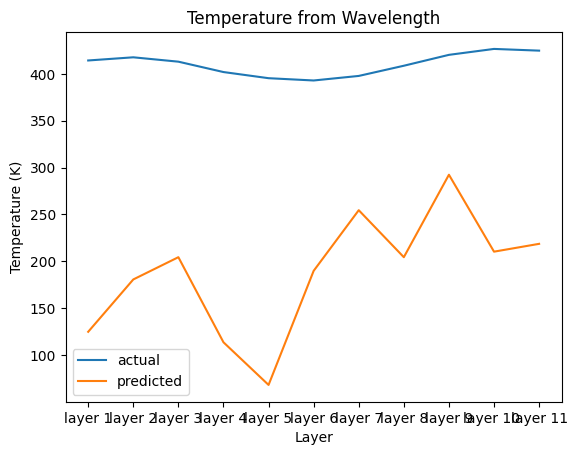

In [19]:
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(actual))
plt.plot(y_train.columns, actual.values[2], label='actual')
plt.plot(y_train.columns, pred.values[2],  label='predicted')

if direction:
    plt.title("Wavelength from Temperature")
    plt.xlabel("Wavlength")
    plt.ylabel("Intensity")
else:
    plt.title("Temperature from Wavelength")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

plt.legend()
plt.show()